# 5.2 합성곱 신경망 맛보기

fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현한다.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # ------ 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

이번 예제에서 사용할 fashion_mnist 데이터셋은 토치비전으로 내려받을 수 있다.

In [11]:
# 5-3 fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()])) # No.1
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                 train=False, transform=transforms.Compose([transforms.ToTensor()])) # 앞에서 훈련 데이터셋을 내려받았다면 여기에서는 테스트 데이터셋을 내려받는다.

#### No.1 
torchvision.datasets는 torch.utils.data.Dataset의 하위 클래스로 다양한 데이터셋을 포함한다.  
주요한 파라미터는 다음과 같다.  

첫 번째 파라미터 : FashionMnist를 내려받을 위치를 지정한다.  
download: download를 True로 벼경해주면 첫 번째 파라미터의 위리에 해당 데이터셋이 있는지 확인한 후 내려받는다.  
transform: 이미지를 텐서(0~1)로 변경한다.

In [36]:
# 코드 5-4 fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100) # ------ ①
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)


#### No.1
torch.utils.data.DataLoader()를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록 할 수 있다.  
데이터로더에서 사용하는 파라미터는 다음과 같다.  

첫 번째 파라미터: 데이터를 불러올 데이터셋을 지정한다.  
batch_size: 데이터를 배치로 묶어 준다. 여기에서는 100개 단위로 데이터를 묶어서 불러온다.  

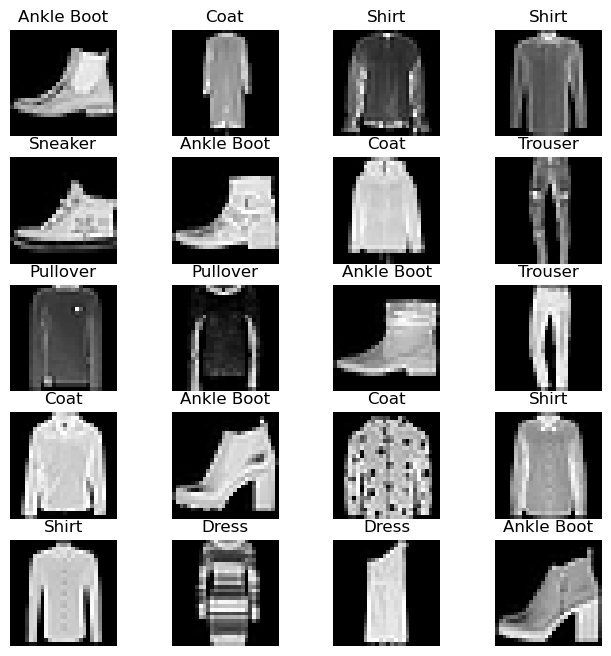

In [13]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'} # ------ 열 개의 클래스

fig = plt.figure(figsize=(8,8)); #  ------ 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));  # No.1
    img = train_dataset[img_xy][0][0,:,:] # No.2
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show() # ------ 20개의 이미지 데이터를 시각적으로 표현

#### No.1
np.random은 무작위로 데이터를 생성할 때 사용한다.  
또한 np.random.randint()는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용한다.  
따라서 random.randint(len(train_dataset))의 의미는 0~(train_dataset의 길이)값을 갖는 분포에서 랜덤한 숫자 한개를 생성하라는 의미이다.  
radnom.randint와 유사하게 사용되는 radnom.rand와 radndom.randn을 예시로 살펴본다.

In [15]:
import numpy as np
np.random.randint(10) # 0~10의 임의의 숫자를 출력

6

In [16]:
np.random.randint(1,10) # 1~9의 임의의 숫자를 출력

9

In [17]:
np.random.rand(8) # 0~1사이의 정규표준분포 난수를 행렬 (1x8) 출력

array([0.89201646, 0.58368165, 0.32834239, 0.7081412 , 0.03843386,
       0.54217007, 0.22696871, 0.17289307])

In [18]:
np.random.rand(4,2) # 0~1 사이의 정규표준분포 난수를 행렬로 (4x2) 출력

array([[0.83554007, 0.34102205],
       [0.51536308, 0.85291876],
       [0.62827477, 0.87908032],
       [0.58771469, 0.88736197]])

In [19]:
np.random.randn(8) # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로(1x8)로 출력

array([-0.66453223, -0.10253761, -0.27770319,  0.73906717,  1.03553578,
       -0.93875943, -1.86657679,  0.19746003])

In [20]:
np.random.randn(4,2) # 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로(4x2)로 출력

array([[ 0.41398087, -0.13594407],
       [ 0.63582662,  1.04633684],
       [ 0.76138011, -1.21524366],
       [-0.63175247, -2.45871324]])

#### No.2 
train_dataset을 이용한 3차원 배열을 생성한다.  
배열에 대한 사용은 다음 예시를 참고.

In [22]:
import numpy as np
examp = np.arange(0, 100, 3) # 1~99의 숫자에서 3씩 건너뛴 행려를 생성
examp.resize(6,4) # 행렬의 크기를 6x4로 수정
print(examp)
print(examp[3]) # 3행에 해당하는 모든 요소(값)들을 출력 (행과 열은 0부터 시작)
print(examp[3,3]) # 3행의 3번째 열에 대한 값을 출력
print(examp[3][3]) #위와 동일

[[ 0  3  6  9]
 [12 15 18 21]
 [24 27 30 33]
 [36 39 42 45]
 [48 51 54 57]
 [60 63 66 69]]
[36 39 42 45]
45
45


In [23]:
# 따라서 train_dataset[img_xy][0][0,:,:]의 의미는 다음 예시로 출력 결과를 유추해 볼 수 있다.
examp = np.arange(0, 500, 3)
examp.resize(3,5,5)
examp

array([[[  0,   3,   6,   9,  12],
        [ 15,  18,  21,  24,  27],
        [ 30,  33,  36,  39,  42],
        [ 45,  48,  51,  54,  57],
        [ 60,  63,  66,  69,  72]],

       [[ 75,  78,  81,  84,  87],
        [ 90,  93,  96,  99, 102],
        [105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132],
        [135, 138, 141, 144, 147]],

       [[150, 153, 156, 159, 162],
        [165, 168, 171, 174, 177],
        [180, 183, 186, 189, 192],
        [195, 198, 201, 204, 207],
        [210, 213, 216, 219, 222]]])

In [24]:
examp[2][0][3]

159

합성곱 신경망과 합성곱 신경망이 아닌 심층 신경망의 비교를 위해 먼저 심층 신경망을 생성한 후 학습시켜본다.  
즉, ConvNet이 적용되지 않은 네트워크를 먼저 만들어본다.

In [33]:
# 5-6 심층신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self): #No.1
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256) # No.2
        self.drop = nn.Dropout(0.25) # No.3
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data): # No.4
        out = input_data.view(-1, 784) # No.5
        out = F.relu(self.fc1(out)) # No.6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


#### No.1
클래서(class)형태의 모델은 항상 torch.nn.Module을 상속 받는다.  
__init__()은 객체가 갖는 속성 값을 초기화 하는 역할을 하며, 객체가 생성될 때 자동으로 호출된다.  
super(FashionDNN, self).__init__()은 FashionDNN이라는 부모(super)클래스를 상속받겠다는 의미이다.  

#### No.2
nn은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여있는 패키지이며, Linear는 단순 선형 회귀 모델을 만들 때 사용한다. 파라미터는 다음과 같다.
* in_features: 입력의 크기
* out_features: 출력의 크기
실제로 연산이 진행되는 forward() 부분에서는 첫 번째 파라미터 값만 넘겨주게 되며, 두 번째 파라미터에서 정의된 크기가 forward()연산의 결과가 된다.  

#### No.3
torch.nn.Dropout(p)는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커진다.  
예를들어 p=0.3이라는 의미는 전체 값중 0.3의 확률로 0이 된다는 것이며, 0이 되지않는 0.7에 해당하는 값은 (1/(1-0.7))만큼 커진다.

#### No.4
forward() 함수는 모델이 학습 데이터를 입력받아서 순전파(forward propagation) 학습을 진행시키며, 반드시 forward라는 이름의 함수여야 한다.  
즉, forward()는 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수이며, 객체를 데이터와 함께 호출하면 자동으로 실행된다.  
이때 순전파 연산이란 H(x)^2식에 입력 x로부터 예측된 y를 얻는 것 이다.

#### No.5
파이토치에서 사용하는 뷰(view)는 넘파이의 reshape과 같은 역할로 텐서의 크기를 변경해주는 역할을 한다.  
따라서 input_data.view(-1, 784)는 input_data를 (?, 784)의 크기로 변경하라는 의미이다.  다시 말해서 2차원의 텐서로 변경하되, (?,784)의 크기로 변경하라는 의미이다.  

#### No.6
활성화 함수를 지정할 때는 다음 두가지 방법이 가능하다.
* F.relu(): forward() 함수에서 정의
* nn.ReLU(): __init__() 함수에서 정의
활성화 함수 사용에 한정하여 이 둘 간의 차이는 간단히 사용하는 위치라고 정의한다.  
하지만 근본적으로는 nn.functional.xx()(혹은 F.xx())와 nn.xx()는 사용 방법에 차이가 있다.  
nn.Conv2d에서 input_channel과 output_channel을 사용해서 연산했다면, functional.conv2d는 입력(input)과 가중치(weight)를 직접 넣어준다.  
이때 직접 넣어준다는 의미는 가중치를 전달 해야할 때마다 가중치 값을 새로 정의해야함을 의미한다.  
다음은 nn.xx와 nn.functional.xx를 비교한 표이다.  
<img src="표5-1.jpg" width="800" height="400"/>

모델을 학습시키기 전에 손실 함수, 학습률, 옵티마이저에 대해 정의한다.

In [30]:
# 5-7 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()

criterion = nn.CrossEntropyLoss() # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # No.1
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [37]:
num_epochs = 5
count = 0
loss_list = [] # ------ ①
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: # ------ ②
        images, labels = images.to(device), labels.to(device) # ------ ③

        train = Variable(images.view(100, 1, 28, 28)) # ------ ④
        labels = Variable(labels)

        outputs = model(train) # ------ 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): # ------ count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total # ------ ⑤
            loss_list.append(loss.data) # ------ ①′
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5911379456520081, Accuracy: 83.22000122070312%
Iteration: 1000, Loss: 0.45724380016326904, Accuracy: 84.80000305175781%
Iteration: 1500, Loss: 0.34912896156311035, Accuracy: 85.12999725341797%


KeyboardInterrupt: 